# Использование машинного обучения для предсказания цены акций, добывающих золото

За основу я взял notebook, опубликованный на github. В данном notebook рассмотрен анализ цен золота и акций золотодобывающих компаний при помощи методов машинного анализа: линейная регрессия, кластерный анализ и случайный лес. Сразу предупреждаю, что в данном посте нет попытки показать текущую ситуацию и предсказать дальнейшее направление. Так же в данной статье не стоит цель вознести или опровергнуть возможности машинного обучения для анализа цен акций или других инструментов. Основная задача - натолкнуть тех, кто заинтерисуется и услушать конструктивную критику в свой адрес. 

In [1]:
pip install yfinance --upgrade --no-cache-dir

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=f06d362732cc78c61a39ace6c3bc0953a3d5a7630b17466b71c6e3bc67780adc
  Stored in directory: /tmp/pip-ephem-wheel-cache-zregbrpj/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [2]:
#Загружаю библиотеки

import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Загрузка данных

За цену золота возьмем стоимость бирежевого инвестиционного фонда SPDR Gold Trust акции которого обеспечены на 100% благородным металлом. Сравниваться котировки будут с ценами на акции золотодобывающих компаний:
* Newmont Goldcorp (NMM)
* Barrick Gold (GOLD)
* AngloGold Ashanti (AU)
* Kinross Gold (KGC)
* Newcrest Mining	(NCM)
* Полюс Золото (PLZL)
* Полиметалл (POLY)
* Селигдар (SELG)

In [3]:
gold = pd.DataFrame(yf.download("GLD", end='2019-12-31')['Adj Close'])

[*********************100%***********************]  1 of 1 completed


In [4]:
gold = gold.reset_index()

In [5]:
gold.columns = ["Date","gold_price"]

Необходимо сдвинуть цену на золото, так как нас будет интерисовать как вчерашняя цена влияла на сегодняшнюю цену акций. 

In [6]:
gold["gold_price"] = gold["gold_price"].shift(1)

In [7]:
gold_log = gold.copy()
gold_log['gold_price'] = np.log(gold_log['gold_price'].pct_change()+1)

In [8]:
shares=["NMM.SG","GOLD","AU","KGC","NCM.AX","PLZL.ME","POLY.ME","SELG.ME"]

In [9]:
data= yf.download(shares, end='2019-12-31')['Adj Close']

[*********************100%***********************]  8 of 8 completed


In [10]:
data_log = np.log(data.pct_change()+1)

In [11]:
# удалим индекс и сделаем новую колонку с датой
data = data.reset_index()
data_log = data_log.reset_index()

In [12]:
all_data=pd.DataFrame() # создадим массив, который будет хранить все данные
all_data_log=pd.DataFrame()

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9955 entries, 0 to 9954
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     9955 non-null   datetime64[ns]
 1   AU       5386 non-null   float64       
 2   GOLD     8798 non-null   float64       
 3   KGC      9782 non-null   float64       
 4   NCM.AX   5476 non-null   float64       
 5   NMM.SG   2927 non-null   float64       
 6   PLZL.ME  2455 non-null   float64       
 7   POLY.ME  1641 non-null   float64       
 8   SELG.ME  2047 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 700.1 KB


In [14]:
# создадим массив с котировками
for index in range(len(shares)):
    stock=pd.DataFrame()
    # трансформируем данные
    stock=data.loc[:, ("Date",shares[index])]
    stock["Date"]=stock["Date"].astype('datetime64[ns]')
    stock.columns=["Date","share_price"]
    test=pd.DataFrame(gold) 
    output=stock.merge(test,on="Date",how="left") # объединение двух наборов данных
    stock["gold_price"]=output["gold_price"]
    stock['share_price']=pd.to_numeric(stock['share_price'], errors='coerce').dropna(0)
    stock['gold_price']=pd.to_numeric(stock['gold_price'], errors='coerce').dropna(0)
    stock["year"]=pd.to_datetime(stock["Date"]).dt.year # Создать колонку с годами для последующей фильтрации
    stock["name"]=shares[index]
    stock = stock.dropna() # удалить все NAN строчки.
    # Создаем колонку с маштабированной ценой акций
    scaler=MinMaxScaler()
    stock["share_price_scaled"]=scaler.fit_transform(stock["share_price"].to_frame())
    # Добавить данные в основной датафрейм
    all_data=all_data.append(stock) #добавляем данные

In [15]:
# похожий массив с лог-доходнорстью
for index in range(len(shares)):
    stock_log=pd.DataFrame()
    # трансформируем данные
    stock_log=data_log.loc[:, ("Date",shares[index])]
    stock_log["Date"]=stock_log["Date"].astype('datetime64[ns]')
    stock_log.columns=["Date","share_price"]
    test=pd.DataFrame(gold_log) 
    output=stock_log.merge(test,on="Date",how="left") # объединение двух наборов данных
    stock_log["gold_price"]=output["gold_price"]
    stock_log['share_price']=pd.to_numeric(stock_log['share_price'], errors='coerce').dropna(0)
    stock_log['gold_price']=pd.to_numeric(stock_log['gold_price'], errors='coerce').dropna(0)
    stock_log["year"]=pd.to_datetime(stock_log["Date"]).dt.year # Создать колонку с годами для последующей фильтрации
    stock_log["name"]=shares[index]
    stock_log = stock_log.dropna() # удалить все NAN строчки.
    # Создаем колонку с маштабированной ценой акций
    scaler=MinMaxScaler()
    stock_log["share_price_scaled"]=scaler.fit_transform(stock_log["share_price"].to_frame())
    # Добавить данные в основной датафрейм
    all_data_log=all_data_log.append(stock_log) #добавляем данные

In [16]:
# оставляю данные только с 2015 по 2019
all_data_15 = all_data[(all_data['year']>2014)&(all_data['year']<2020)]
all_data_15_log = all_data_log[(all_data_log['year']>2014)&(all_data_log['year']<2020)]

In [17]:
all_data_15.head()

,Date,share_price,gold_price,year,name,share_price_scaled
8655,2015-01-02,14.269927,113.580002,2015,NMM.SG,0.052072
8656,2015-01-05,14.845476,114.080002,2015,NMM.SG,0.071190
8657,2015-01-06,15.601913,115.800003,2015,NMM.SG,0.096317
8658,2015-01-07,15.645762,117.120003,2015,NMM.SG,0.097773
8659,2015-01-08,15.517859,116.430000,2015,NMM.SG,0.093525


In [18]:
all_data_15_log.head()

,Date,share_price,gold_price,year,name,share_price_scaled
8655,2015-01-02,0.023645,-0.014162,2015,NMM.SG,0.400717
8656,2015-01-05,0.039541,0.004393,2015,NMM.SG,0.434568
8657,2015-01-06,0.049698,0.014965,2015,NMM.SG,0.456198
8658,2015-01-07,0.002807,0.011334,2015,NMM.SG,0.356343
8659,2015-01-08,-0.008209,-0.005909,2015,NMM.SG,0.332886


## 2. Анализ данных

Анализ данных лучше начинать с их визуального представления, что поможет Вам лучше их понять.

### 2.1 График изменение цены на золото

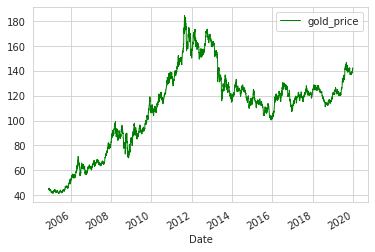

In [49]:
gold[['Date','gold_price']].set_index('Date').plot(color="green", linewidth=1.0)
plt.show()

### 2.2. Построение графика pairplot для цены акций Полюса и Barrick Gold за последние пять лет

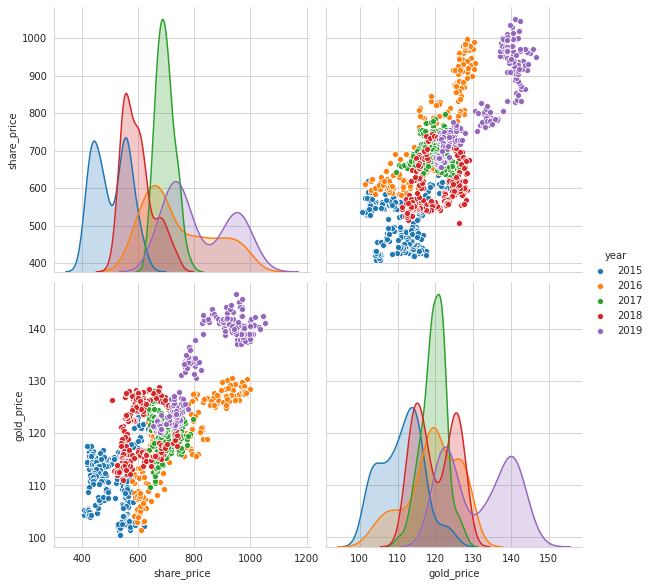

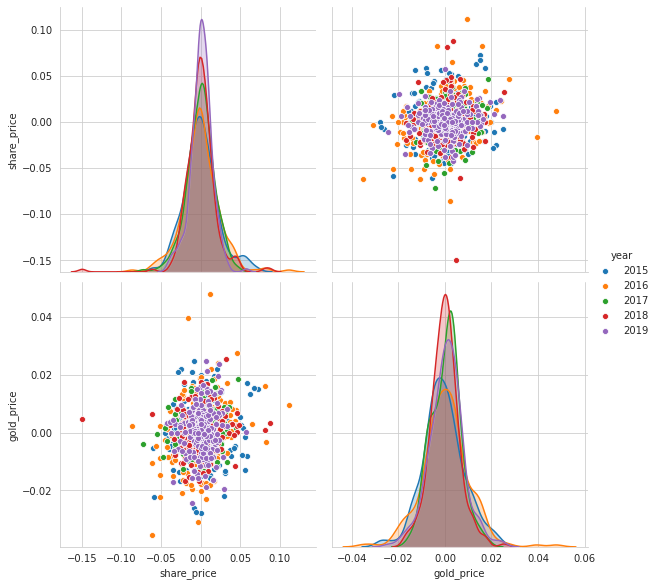

In [50]:

palette=sns.cubehelix_palette(18, start=2, rot=0, dark=0, light=.95, reverse=False)
sns.pairplot(all_data[(all_data['name']=="POLY.ME")&(all_data['year']>2014)&(all_data['year']<2020)].\
             drop(["share_price_scaled"],axis=1), hue="year",height=4)

palette=sns.cubehelix_palette(18, start=2, rot=0, dark=0, light=.95, reverse=False)
sns.pairplot(all_data_log[(all_data_log['name']=="POLY.ME")&(all_data_log['year']>2014)&(all_data_log['year']<2020)].\
             drop(["share_price_scaled"],axis=1), hue="year",height=4)

plt.show()

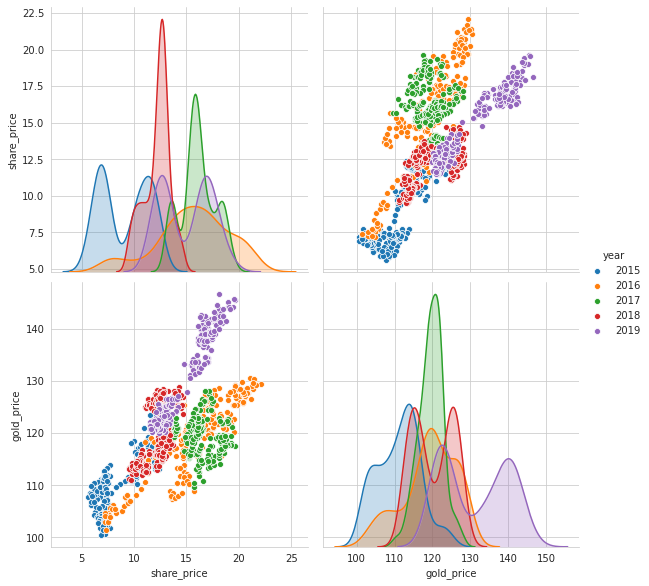

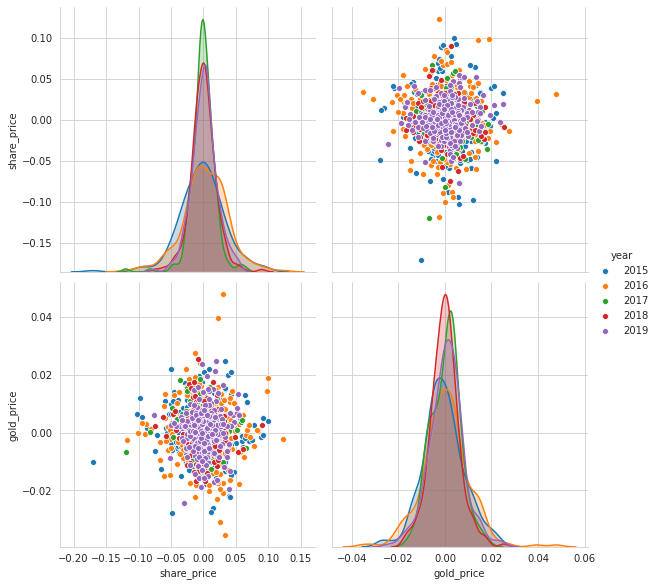

In [51]:
palette=sns.cubehelix_palette(18, start=2, rot=0, dark=0, light=.95, reverse=False)
sns.pairplot(all_data[(all_data['name']=="GOLD")&(all_data['year']>2014)&(all_data['year']<2020)].\
             drop(["share_price_scaled"],axis=1), hue="year",height=4)

palette=sns.cubehelix_palette(18, start=2, rot=0, dark=0, light=.95, reverse=False)
sns.pairplot(all_data_log[(all_data_log['name']=="GOLD")&(all_data_log['year']>2014)&(all_data_log['year']<2020)].\
             drop(["share_price_scaled"],axis=1), hue="year",height=4)

plt.show()

Парный график позволяет увидеть  распределение данных показывая парные отношения в наборе данных и одномерное распределение данных для каждой переменной. Так же за счет палитры можно посмотреть как эти данные менялись в различные года. 

В построенном графике особый интерес представляют за 2016 и 2019 года, так как похоже что цена акции Полюса, Barrick Gold и цена на золото выстроились вдоль одной линии. Так же можно сделать заключение благодоря графикам распределения, что цена на золото и акции двигались постепенно в сторону более высоких значений.

### 2.3 Violinplot для цены на золото

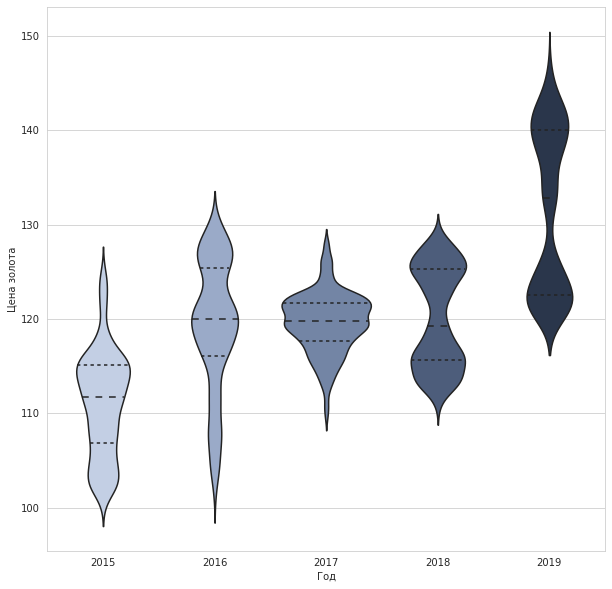

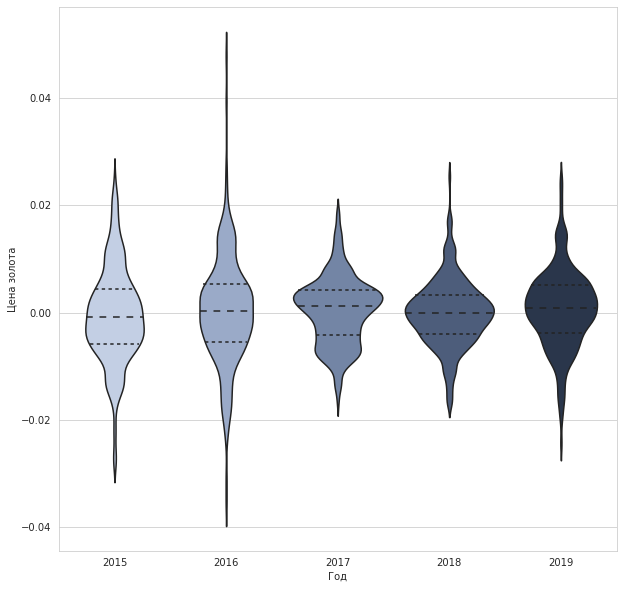

In [22]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
palette=sns.cubehelix_palette(5, start=2.8, rot=0, dark=0.2, light=0.8, reverse=False)

sns.violinplot(x="year", y="gold_price", data=all_data_15[["gold_price","year"]],
               inner="quart", palette=palette, trim=True)
plt.xlabel("Год")
plt.ylabel("Цена золота")

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
palette=sns.cubehelix_palette(5, start=2.8, rot=0, dark=0.2, light=0.8, reverse=False)

sns.violinplot(x="year", y="gold_price", data=all_data_15_log[["gold_price","year"]],
               inner="quart", palette=palette, trim=True)
plt.xlabel("Год")
plt.ylabel("Цена золота")

plt.show()

### 2.4 Violinplot для нескольких акций

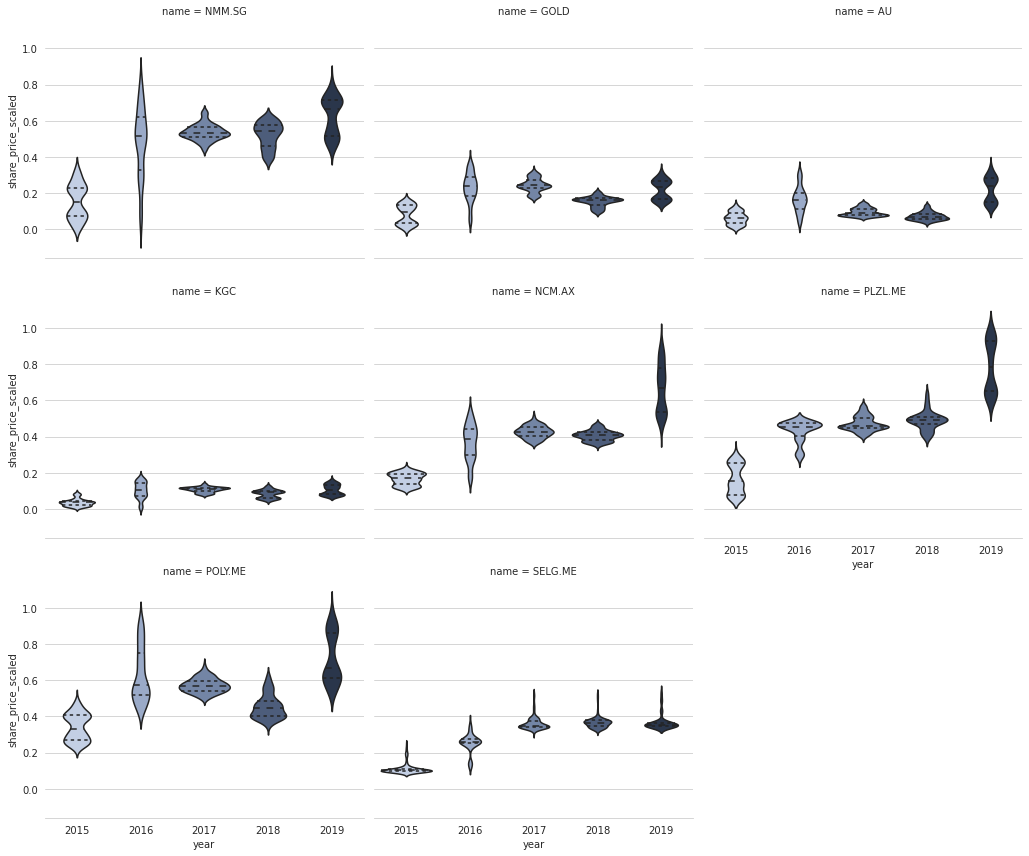

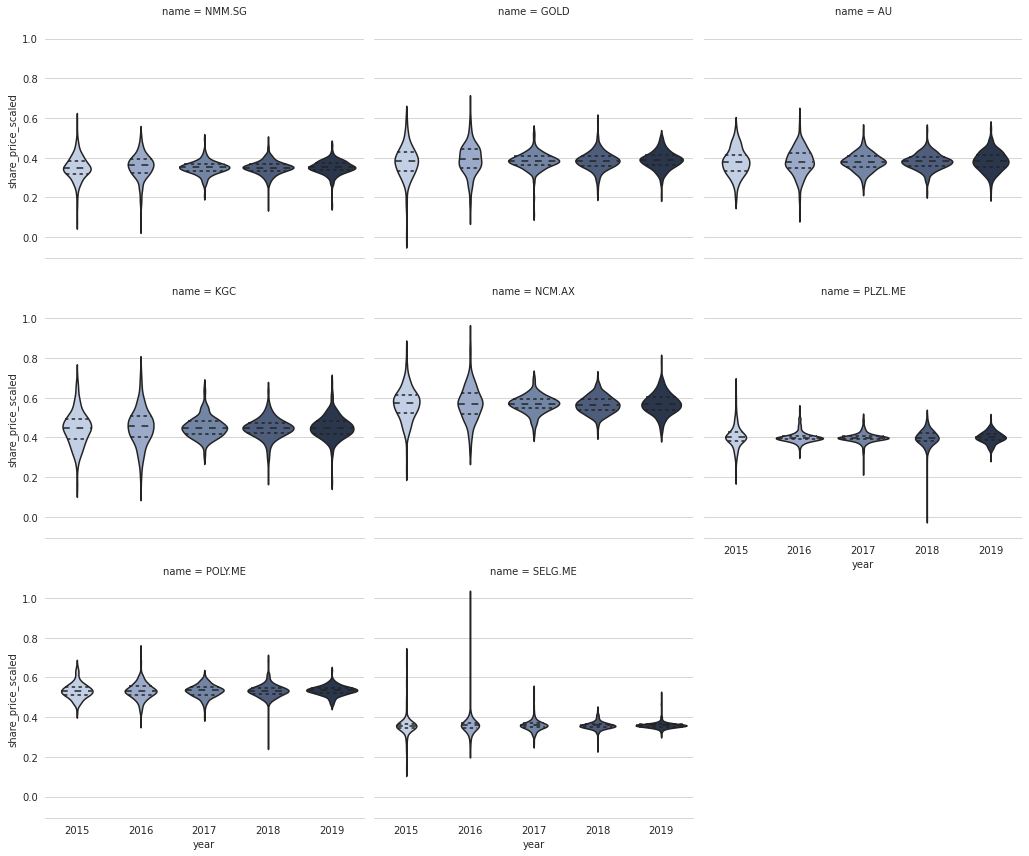

In [23]:
sns.catplot(x="year", y="share_price_scaled", col='name', col_wrap=3,kind="violin",
               split=True, data=all_data_15,inner="quart", palette=palette, trim=True, height=4, aspect=1.2)
sns.despine(left=True)

sns.catplot(x="year", y="share_price_scaled", col='name', col_wrap=3,kind="violin",
               split=True, data=all_data_15_log,inner="quart", palette=palette, trim=True, height=4, aspect=1.2)
sns.despine(left=True)

Большое колебание цен на золото было отмечено согласно графикам в 2016 и 2019 году. Как можно отметить согласно графикам на следующем рисунке этому так же были подвержены некоторые компании, такие как Newmont Mining, Barrick Gold, AngloGold Ashanti, Newcrest Mining и Polymetal.  Так же необходимо отметить, что все цены отмаштабированы в диапазоне от 0 до 1 и это может приводить к неточностям в интерпретации.

Далее построим графики распределения для одной российской компаний - Polymetal и одной иностранной - Barrick Gold

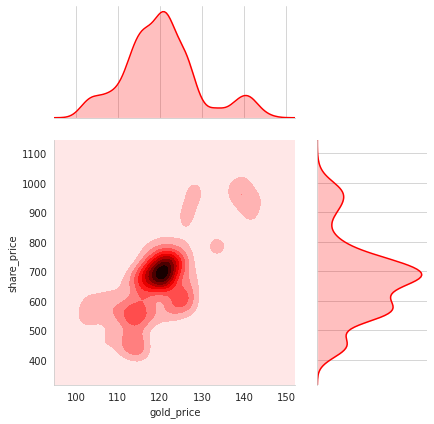

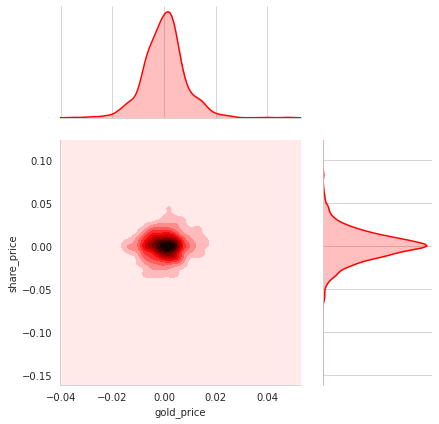

In [24]:
sns.jointplot("gold_price", "share_price",data=all_data_15[all_data_15['name']=="POLY.ME"],kind="kde",
              height=6,ratio=2,color="red").plot_joint(sns.kdeplot, zorder=0, n_levels=20)

sns.jointplot("gold_price", "share_price",data=all_data_15_log[all_data_15_log['name']=="POLY.ME"],kind="kde",
              height=6,ratio=2,color="red").plot_joint(sns.kdeplot, zorder=0, n_levels=20)
plt.show()

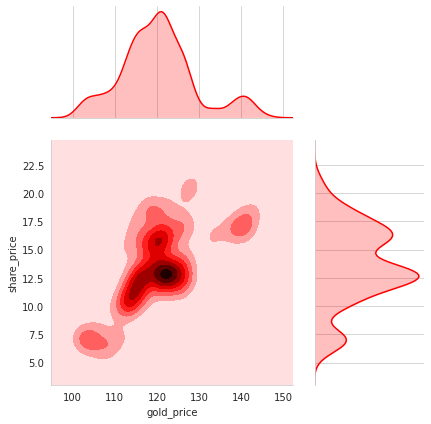

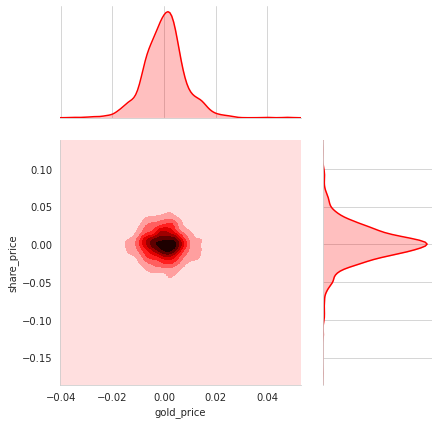

In [25]:
sns.jointplot("gold_price", "share_price",data=all_data_15[all_data_15['name']=="GOLD"],kind="kde",
              height=6,ratio=2,color="red").plot_joint(sns.kdeplot, zorder=0, n_levels=20)

sns.jointplot("gold_price", "share_price",data=all_data_15_log[all_data_15_log['name']=="GOLD"],kind="kde",
              height=6,ratio=2,color="red").plot_joint(sns.kdeplot, zorder=0, n_levels=20)
plt.show()

Необходимо обратить внимание на распределение цены акций для двух компаний и станет видно, что форма графика плотностей у них совпадает.

### 2.5 График зависимости цены акций различных компаний от цены золота 

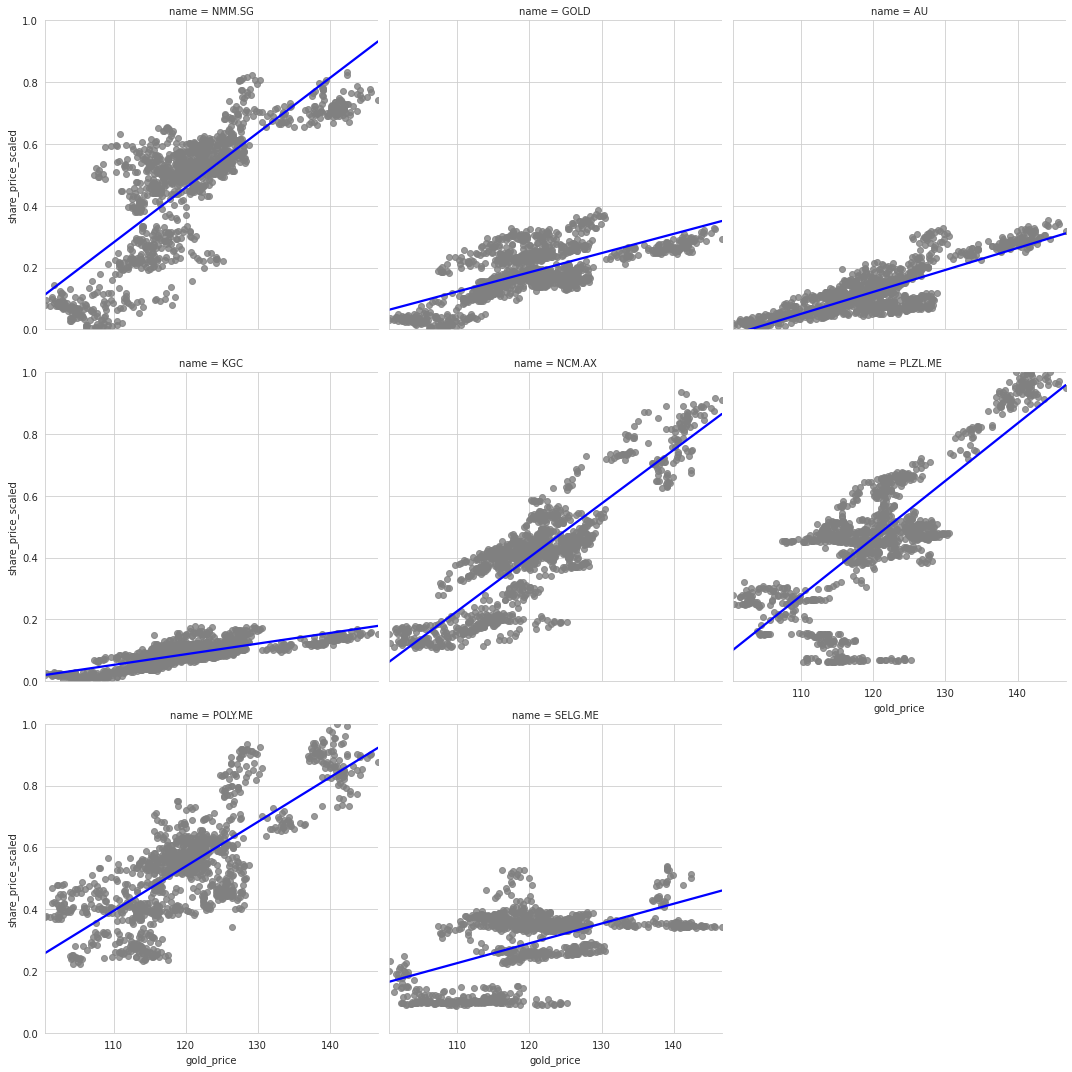

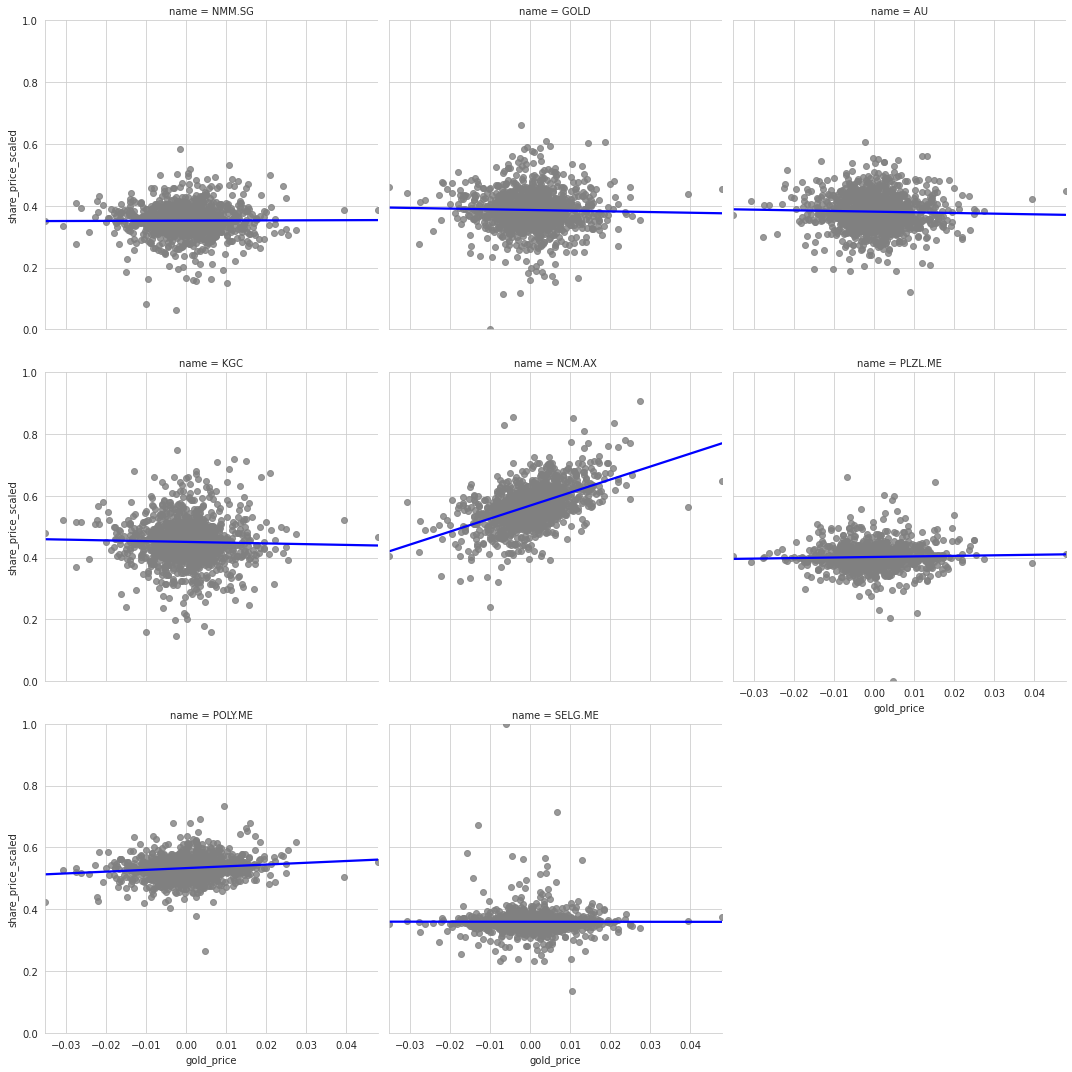

In [26]:
sns.lmplot(x="gold_price", y="share_price_scaled", col="name",ci=None, col_wrap=3, 
           data=all_data_15, order=1,line_kws={'color': 'blue'},scatter_kws={'color': 'grey'}).set(ylim=(0, 1))

sns.lmplot(x="gold_price", y="share_price_scaled", col="name",ci=None, col_wrap=3, 
           data=all_data_15_log, order=1,line_kws={'color': 'blue'},scatter_kws={'color': 'grey'}).set(ylim=(0, 1))

plt.show()

На самом деле много не удасться увидеть на этих графииках, хотя у некоторых акций похоже прослеживается зависимость.

Следующим шагом можно попытаться раскрасить графики в зависимости от годов.

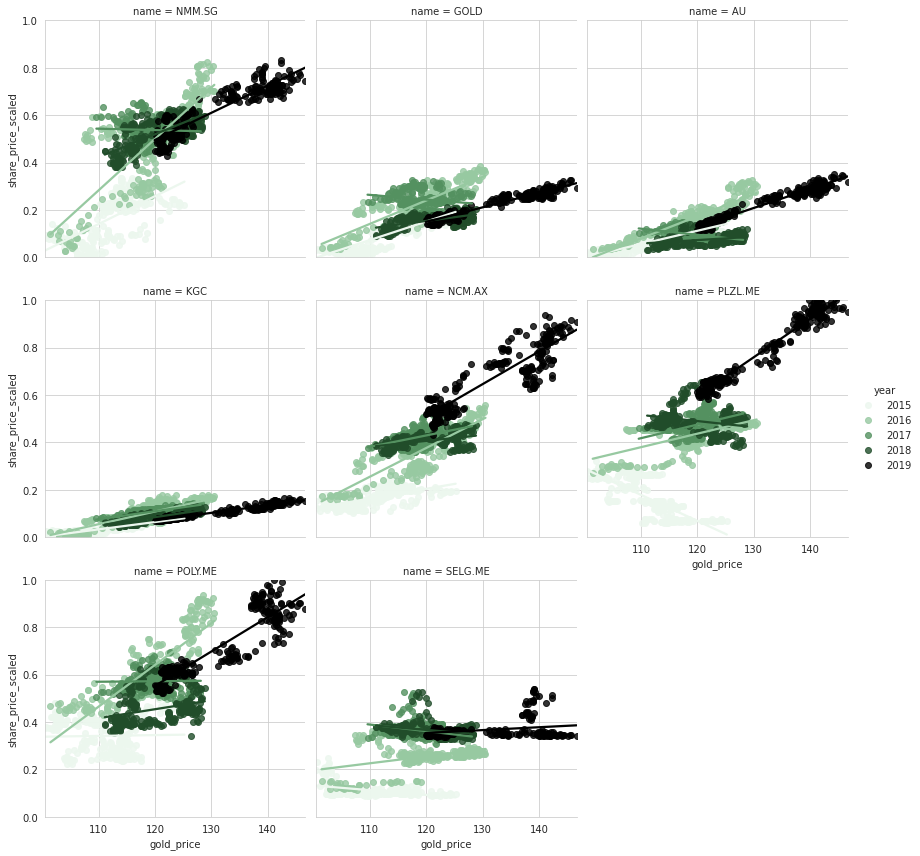

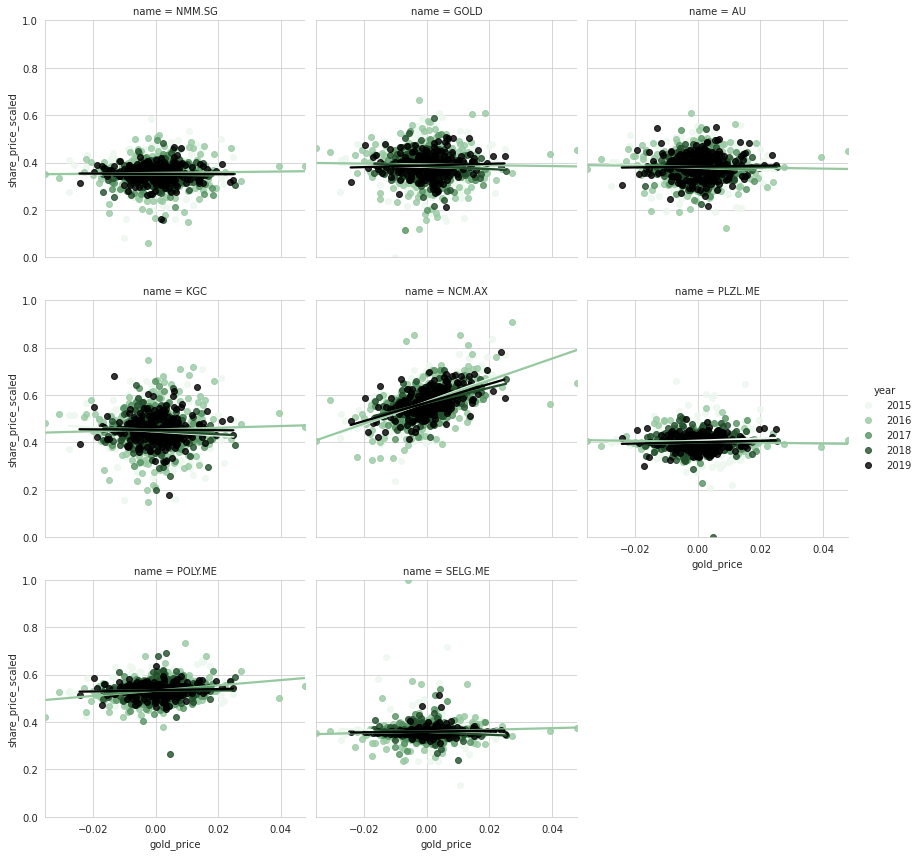

In [27]:
palette=sns.cubehelix_palette(5, start=2, rot=0, dark=0, light=.95, reverse=False)
sns.lmplot(x="gold_price", y="share_price_scaled",hue="year", col="name",ci=None, 
           col_wrap=3, data=all_data_15, order=1,palette=palette,height=4).set(ylim=(0, 1))

palette=sns.cubehelix_palette(5, start=2, rot=0, dark=0, light=.95, reverse=False)
sns.lmplot(x="gold_price", y="share_price_scaled",hue="year", col="name",ci=None, 
           col_wrap=3, data=all_data_15_log, order=1,palette=palette,height=4).set(ylim=(0, 1))

plt.show()

Тут картинка немного лучше в том плане, что у некоторых компаний наблюдается вытягивание облака данных вдоль прямой в некоторые года, что может указывать на существование зависимости.

# 3 Машинное обучение и предсказание

Приведу определение для машинного обучения из [Википедии](https://ru.wikipedia.org/wiki/%D0%9C%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B5_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5): 
Машинное обучение — класс методов искусственного интеллекта, характерной чертой которых является не прямое решение задачи, а обучение в процессе применения решений множества сходных задач. Для построения таких методов используются средства математической статистики, численных методов, методов оптимизации, теории вероятностей, теории графов, различные техники работы с данными в цифровой форме. 

Обычно алгоритмы машинного обучения можно отнести к следущим категориям: обучение с учителем и обучение без учителя. Приведем их определение с одного из сайтов:

Обучение с учителем (Supervised learning) — один из разделов машинного обучения, посвященный решению следующей задачи. Имеется множество объектов (ситуаций) и множество возможных ответов (откликов, реакций). Существует некоторая зависимость между ответами и объектами, но она неизвестна. Известна только конечная совокупность прецедентов — пар «объект, ответ», называемая обучающей выборкой. На основе этих данных требуется восстановить зависимость, то есть построить алгоритм, способный для любого объекта выдать достаточно точный ответ. Для измерения точности ответов определённым образом вводится функционал качества. см. [Ссылки](http://www.machinelearning.ru/wiki/index.php?title=%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81_%D1%83%D1%87%D0%B8%D1%82%D0%B5%D0%BB%D0%B5%D0%BC)) 

Обучение без учителя (Unsupervised learning) — один из разделов машинного обучения. Изучает широкий класс задач обработки данных, в которых известны только описания множества объектов (обучающей выборки), и требуется обнаружить внутренние взаимосвязи, зависимости, закономерности, существующие между объектами. Обучение без учителя часто противопоставляется обучению с учителем, когда для каждого обучающего объекта задаётся «правильный ответ», и требуется найти зависимость между объектами и ответами. см. [Ссылки](http://www.machinelearning.ru/wiki/index.php?title=%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B1%D0%B5%D0%B7_%D1%83%D1%87%D0%B8%D1%82%D0%B5%D0%BB%D1%8F))  

Дальше будут рассмотрены следующие методы машинного обучения:
* Кластерный анализ 
* Линейная регрессия 
* Случайный лес 

При помощи данных алгоритмов можно оценить переоцененые или недооценены акции относительно цены на золота и возможное движение на следующий день. Напоминаю, что необходимо соблюдать огромную осторожность и выводы из этого поста использовать на собственный страх и риск. Так же напоминаю, что основная цель, которую я приследую - показать потенциал машинного обучения для оценки акций. 

### 3.1. Кластерный анализ для акций Barrick Gold

Кластеризация - это задача разбиения множества объектов на группы, называемые кластерами. Внутри каждой группы должны оказаться «похожие» объекты, а объекты разных группы должны быть как можно более отличны. см. [Ссылки](https://habr.com/ru/post/101338/).

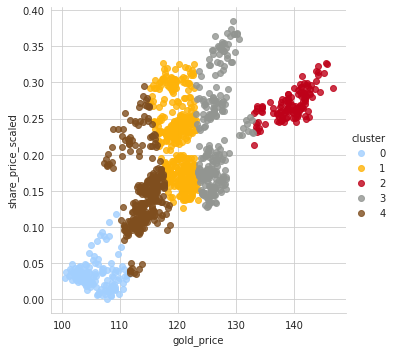

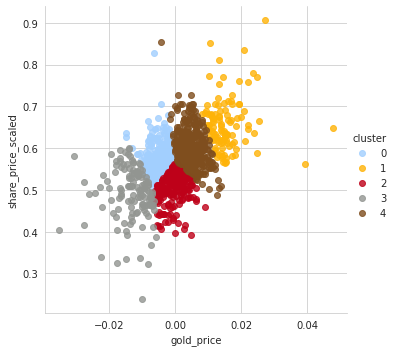

In [28]:
from sklearn.cluster import KMeans

poly=all_data_15[all_data_15['name']=="GOLD"]
# We need to scale also oil price, so clustering is not influenced by the relative size of one axis.
poly=pd.DataFrame(poly)
poly['gold_price_scaled'] = scaler.fit_transform(poly["gold_price"].to_frame())
poly["cluster"] = KMeans(n_clusters=5, random_state=1).fit_predict(poly[["share_price_scaled","gold_price_scaled"]])

# The 954 most common RGB monitor colors https://xkcd.com/color/rgb/
colors = ["baby blue", "amber", "scarlet", "grey","milk chocolate", "windows blue"]
palette=sns.xkcd_palette(colors)

sns.lmplot(x="gold_price", y="share_price_scaled",ci=None,palette=palette, hue="cluster",fit_reg=0 ,data=poly)

poly=all_data_15_log[all_data_15_log['name']=="NCM.AX"]
# We need to scale also oil price, so clustering is not influenced by the relative size of one axis.
poly=pd.DataFrame(poly)
poly['gold_price_scaled'] = scaler.fit_transform(poly["gold_price"].to_frame())
poly["cluster"] = KMeans(n_clusters=5, random_state=1).fit_predict(poly[["share_price_scaled","gold_price_scaled"]])

# The 954 most common RGB monitor colors https://xkcd.com/color/rgb/
colors = ["baby blue", "amber", "scarlet", "grey","milk chocolate", "windows blue"]
palette=sns.xkcd_palette(colors)

sns.lmplot(x="gold_price", y="share_price_scaled",ci=None,palette=palette, hue="cluster",fit_reg=0 ,data=poly)

plt.show()

Кластерный анализ используется в большом количестве задач машинного обучения. Но я его привел только в ознакомительных целях, так как в данном виде он не приносит много пользы для нашего анализа. 

### 3.2. Линейная регрессия между акциями Barrick Gold и ценой на золото

Далее построим обычную линейную регрессию при помощи обучения с учителем. Цель состоит в том, чтобы оценить прогноз данных за последние 100 дней 2019 года на основании данных 2018/2019 годов (без учета оцениваемых). Тренировочные данные - это данные, используемые для построения модели, а тестовые данные - те, которые попытаемся предсказать.

NMM.SG
Coefficients:  0.6629423053739908
[[1.       0.790953]
 [0.790953 1.      ]]
Mean Absolute Error: 6.063058573972694
Mean Squared Error: 39.21188296210148
Root Mean Squared Error: 6.261939233344689


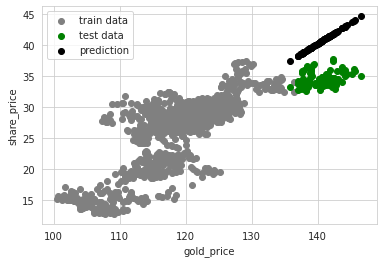

GOLD
Coefficients:  0.3355465472461071
[[1.         0.67139243]
 [0.67139243 1.        ]]
Mean Absolute Error: 3.3769293704374657
Mean Squared Error: 11.756813554455096
Root Mean Squared Error: 3.4288210152259473


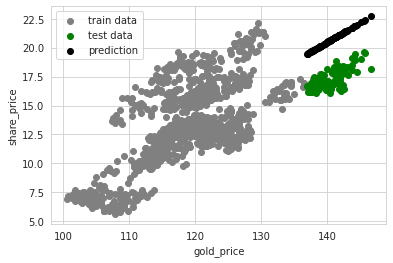

AU
Coefficients:  0.31252669952857776
[[1.         0.67830589]
 [0.67830589 1.        ]]
Mean Absolute Error: 2.2471377544809683
Mean Squared Error: 5.789211153877581
Root Mean Squared Error: 2.4060779608893768


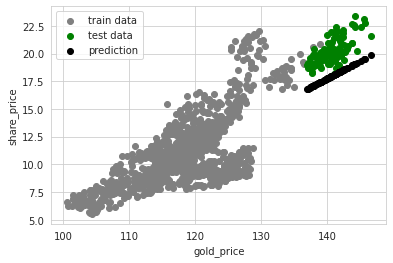

KGC
Coefficients:  0.10497710362302158
[[1.         0.78266367]
 [0.78266367 1.        ]]
Mean Absolute Error: 1.0619841670062968
Mean Squared Error: 1.1604078059463863
Root Mean Squared Error: 1.0772222639485254


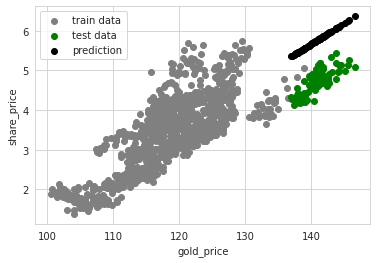

NCM.AX
Coefficients:  0.5623005799590818
[[1.         0.79891272]
 [0.79891272 1.        ]]
Mean Absolute Error: 2.0335289996635937
Mean Squared Error: 5.836462091267656
Root Mean Squared Error: 2.415877085297937


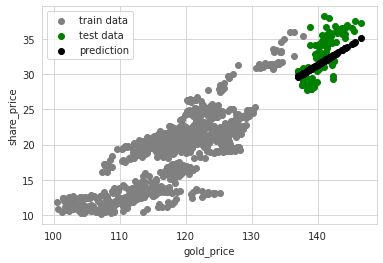

PLZL.ME
Coefficients:  105.31038474468757
[[1.         0.60373084]
 [0.60373084 1.        ]]
Mean Absolute Error: 1333.6593478410398
Mean Squared Error: 1827417.2423876964
Root Mean Squared Error: 1351.819974104428


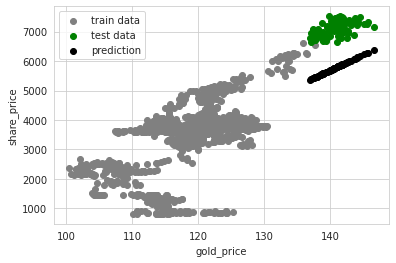

POLY.ME
Coefficients:  10.772023429299809
[[1.         0.63694034]
 [0.63694034 1.        ]]
Mean Absolute Error: 69.33753863275061
Mean Squared Error: 6800.525447108329
Root Mean Squared Error: 82.46529844187995


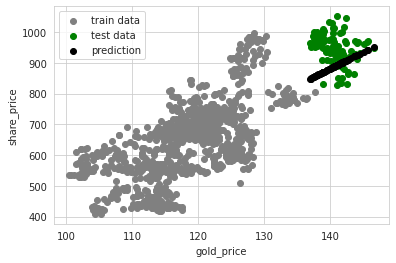

SELG.ME
Coefficients:  0.15570348678870732
[[1.         0.51630147]
 [0.51630147 1.        ]]
Mean Absolute Error: 1.8096071903165585
Mean Squared Error: 4.039450515732427
Root Mean Squared Error: 2.009838430255633


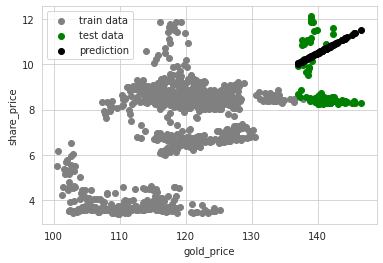

In [29]:
for sh in shares:
  print(sh)
  # Подготовка данных
  share_18=pd.DataFrame()
  #share_18=all_data_15[(all_data_15['name']==sh) & (all_data_15['year']>2017 )] # Взять данные 2018/19
  share_18=all_data_15[(all_data_15['name']==sh)] # Взять данные 2018/19
  share_18=share_18[["share_price","gold_price"]].reset_index()
  # Для построения будет использована только одна переменная. Для большего числа будет использована модель RandomForest
  # Разделим данные на обучающие и тестовые
  train = share_18[:-100]
  test = share_18[-100:]

  x_train=train["gold_price"].to_frame() # преобразовать Series в numpy.ndarray
  y_train=train['share_price'].to_frame()
  x_test=test["gold_price"].to_frame() # преобразовать Series в numpy.ndarray
  y_test=test['share_price'].to_frame()

  # Построение модели линейной регрессии и ее тренировка
  regr = LinearRegression()
  regr.fit(x_train,y_train)

  # Узнать коэффициент
  print("Coefficients: ",  float(regr.coef_))
  print(np.corrcoef(x_train,y_train, rowvar=False))
  # Узнать ошибки
  y_pred = regr.predict(x_test)
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
  print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
  
  # Plot outputs using matplotlib
  plt_train=plt.scatter(x_train["gold_price"],y_train,   color='grey')
  plt_test=plt.scatter(x_test["gold_price"],y_test,   color='green')
  plt_pred=plt.scatter(x_test["gold_price"], y_pred,  color='black')

  plt.xlabel("gold_price")
  plt.ylabel("share_price")
  plt.legend((plt_train, plt_test,plt_pred),("train data", "test data","prediction"))
  plt.show()


NMM.SG
2.639980302199252e-05
[[1.         0.00513807]
 [0.00513807 1.        ]]
Coefficients:  0.014600659056805394
Mean Absolute Error: 0.010571436392638005
Mean Squared Error: 0.00018573172330899016
Root Mean Squared Error: 0.01362834264718165


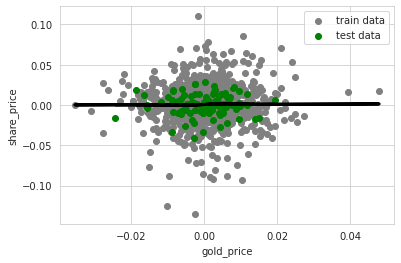

GOLD
0.0011289867997769099
[[ 1.        -0.0336004]
 [-0.0336004  1.       ]]
Coefficients:  -0.11475475461436009
Mean Absolute Error: 0.014555395726699975
Mean Squared Error: 0.0003775923653052965
Root Mean Squared Error: 0.01943173603426355


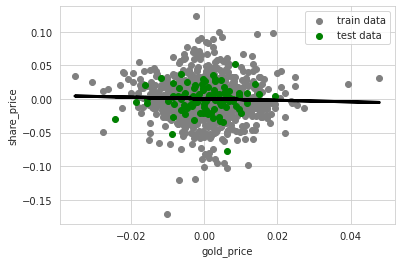

AU
0.0011625769376854
[[ 1.         -0.03409658]
 [-0.03409658  1.        ]]
Coefficients:  -0.13513662547728394
Mean Absolute Error: 0.024878689842528487
Mean Squared Error: 0.0009303140282548638
Root Mean Squared Error: 0.03050104962546148


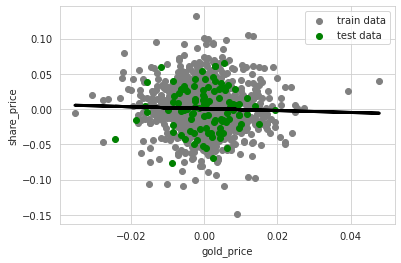

KGC
0.0006875678329989476
[[ 1.         -0.02622151]
 [-0.02622151  1.        ]]
Coefficients:  -0.10991159335091447
Mean Absolute Error: 0.0205402111873904
Mean Squared Error: 0.0007298110509997887
Root Mean Squared Error: 0.027015015287794836


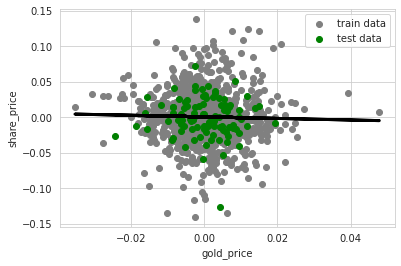

NCM.AX
0.25635290364318464
[[1.         0.50631305]
 [0.50631305 1.        ]]
Coefficients:  1.3535179947536282
Mean Absolute Error: 0.01223049686995653
Mean Squared Error: 0.00023323111214692204
Root Mean Squared Error: 0.015271905976233681


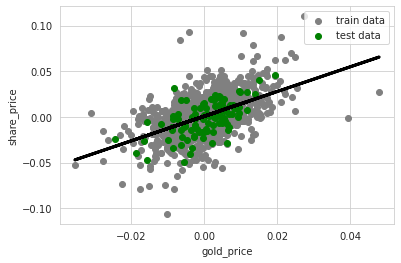

PLZL.ME
0.0017658122314111457
[[1.         0.04202157]
 [0.04202157 1.        ]]
Coefficients:  0.10348940277406418
Mean Absolute Error: 0.01170133248108138
Mean Squared Error: 0.00021390708260202892
Root Mean Squared Error: 0.014625562642238039


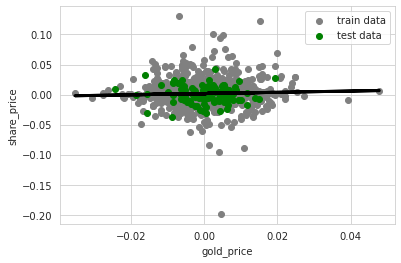

POLY.ME
0.019106982487294144
[[1.         0.13822801]
 [0.13822801 1.        ]]
Coefficients:  0.34747979033601567
Mean Absolute Error: 0.011802760103995731
Mean Squared Error: 0.00023087064877414488
Root Mean Squared Error: 0.015194428214781393


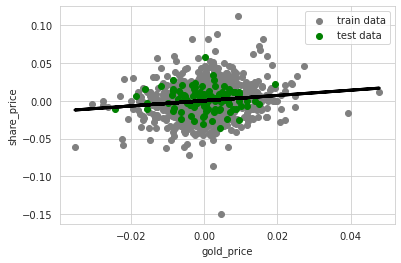

SELG.ME
3.2102873124051357e-05
[[ 1.         -0.00566594]
 [-0.00566594  1.        ]]
Coefficients:  -0.02279643358741134
Mean Absolute Error: 0.011213522665469444
Mean Squared Error: 0.000483902489750911
Root Mean Squared Error: 0.021997783746343882


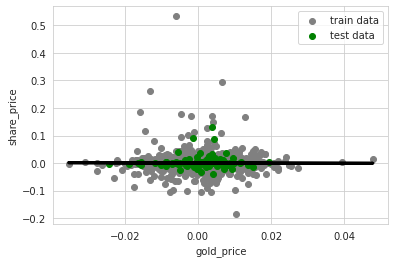

In [30]:
for sh in shares:
  print(sh)
  # Подготовка данных
  share_18_log=pd.DataFrame()
  #share_18=all_data_15[(all_data_15['name']==sh) & (all_data_15['year']>2017 )] # Взять данные 2018/19
  share_18_log=all_data_15_log[(all_data_15_log['name']==sh)] # Взять данные 2018/19
  share_18_log=share_18_log[["share_price","gold_price"]].reset_index()
  # Для построения будет использована только одна переменная. Для большего числа будет использована модель RandomForest
  # Разделим данные на обучающие и тестовые
  train = share_18_log[:-100]
  test = share_18_log[-100:]

  x_train=train["gold_price"].to_frame() # преобразовать Series в numpy.ndarray
  y_train=train['share_price'].to_frame()
  x_test=test["gold_price"].to_frame() # преобразовать Series в numpy.ndarray
  y_test=test['share_price'].to_frame()

  # Построение модели линейной регрессии и ее тренировка
  regr = LinearRegression()
  regr.fit(x_train,y_train)
  print(regr.score(x_train,y_train))
  print(np.corrcoef(x_train,y_train, rowvar=False))

  # Узнать коэффициент
  print("Coefficients: ",  float(regr.coef_))
  # Узнать ошибки
  y_pred = regr.predict(x_test)
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
  print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
  
  # Plot outputs using matplotlib
  plt_train=plt.scatter(x_train, y_train,  color='grey')
  plt_test=plt.scatter(x_test, y_test,  color='green')
  plt.plot(x_train, regr.predict(x_train), color='black', linewidth=3)
  plt.plot(x_test,regr.predict(x_test),  color='black', linewidth=3)
  plt.xlabel("gold_price")
  plt.ylabel("share_price")
  plt.legend((plt_train, plt_test),("train data", "test data"))
  plt.show()

Из построенных выше графиков можно сделать вывод, что цена на золото достаточно не плохо предсказывает цену на акции иностранных компаний на следующий день. В российских компаниях данная картинка выглядит гораздо хуже. Может конечно сложиться ложное впечатление об акциях Селигдар. Но визуальный анализ графика позволяет отбросить это предположение.

### 3.3 Случайный лес на акциях Newmont Goldcorp против цены на золото и акции золотых компаний

Случайный лес - алгоритм машинного обучения, заключающийся в использовании комитета (ансамбля) решающих деревьев. Основная идея заключается в использовании большого ансамбля решающих деревьев, каждое из которых само по себе даёт очень невысокое качество классификации, но за счёт их большого количества результат получается хорошим [Википедия](https://ru.wikipedia.org/wiki/Random_forest).

Алгоритм случайного леса принимает более одной переменной во входных данных для прогнозирования выходных данных. Он работает очень эффективно на больших объемах данных, может обрабатывать множество входных переменных, имеет эффективные методы оценки недостающих данных и многие другие преимущества. Основными недостатками являются([ссылка](http://distrland.blogspot.com/2019/12/random-forest-python.html)):
1. Random forests медленно генерируют прогнозы, потому что у него много деревьев решений. Всякий раз, когда он делает прогноз, все деревья в лесу должны сделать прогноз для одного и того же заданного ввода и затем выполнить голосование по нему. Весь этот процесс занимает много времени.
2. Модель трудно интерпретировать по сравнению с деревом решений, где вы можете легко принять решение, следуя пути в дереве.

Одним из больших преимуществ случайного леса является то, что он может использоваться как для задач классификации, так и для задач регрессии, которые составляют большинство современных систем машинного обучения. Я буду говорить о случайных лесах в классификации, поскольку классификация иногда считается строительным блоком машинного обучения. Ниже вы можете увидеть, как выглядит случайный лес с двумя деревьями:

Помимо цены на золото, мы будем использовать другие переменные для прогнозирования цены акций Newmont Goldcorp. Это будут цены на акции других золотодобывающих иностранных компаний. Я знаю, что это не имеет большого смысла, но мы просто хотим посмотреть, как построить модель такого типа. Это позволит нам увидеть влияние каждого из них на окончательный прогноз.

In [31]:
from sklearn.ensemble import RandomForestRegressor
# 1.- Data Preparation
nmm15=pd.DataFrame()
nmm15=all_data_15[(all_data_15['name']=="NMM.SG") & (all_data_15['year']>2016 )]
nmm15=nmm15[["share_price","gold_price"]].reset_index()

# Load share price of other variables
nmm15['GOLD']=all_data_15[(all_data_15['name']=="GOLD")][-980:].reset_index()['share_price']
nmm15['GOLD'] = nmm15['GOLD'].shift(1)
nmm15['AU']=all_data_15[(all_data_15['name']=="AU")][-980:].reset_index()['share_price']
nmm15['AU'] = nmm15['AU'].shift(1)
nmm15['KGC']=all_data_15[(all_data_15['name']=="KGC")][-980:].reset_index()['share_price']
nmm15['KGC'] = nmm15['KGC'].shift(1)
nmm15['NCM.AX']=all_data_15[(all_data_15['name']=="NCM.AX")][-980:].reset_index()['share_price']
nmm15['NCM.AX'] = nmm15['NCM.AX'].shift(1)

nmm15 = nmm15.drop(nmm15.index[0])

train = nmm15[:-100]
test = nmm15[-100:]

# ["NMM.SG","GOLD","AU","KGC","NCM.AX","PLZL.ME","POLY.ME","SELG.ME"]

x_train=train[["gold_price","GOLD","AU","KGC","NCM.AX"]]
y_train=train['share_price']

x_test=test[["gold_price","GOLD","AU","KGC","NCM.AX",]] 
y_test=test['share_price'].to_frame()


# 2.- Create Randomforest object usinig a max depth=5
regressor = RandomForestRegressor(n_estimators=200, max_depth=5 )

# 3.- Train data
clf=regressor.fit(x_train, y_train)

# 4.- Predict!
y_pred=regressor.predict(x_test)
y_pred_list = list(y_pred)
y_pred=pd.DataFrame(y_pred)


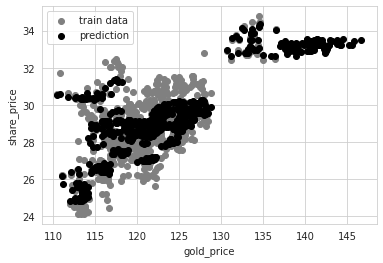

In [32]:
# We are going to have a look at how fitted data looks like:

plt_train=plt.scatter(x_train["gold_price"],y_train,   color='grey')
plt_pred=plt.scatter(nmm15["gold_price"], regressor.predict(nmm15[["gold_price","GOLD","AU","KGC","NCM.AX"]]),  color='black')

plt.xlabel("gold_price")
plt.ylabel("share_price")
plt.legend((plt_train,plt_pred),("train data","prediction"))
plt.show()

In [33]:
# 1.- Data Preparation
nmm15_log=pd.DataFrame()
nmm15_log=all_data_15_log[(all_data_15_log['name']=="NCM.AX") & (all_data_15_log['year']>2016 )]
nmm15_log=nmm15_log[["share_price","gold_price"]].reset_index()

# Load share price of other variables
nmm15_log['GOLD']=all_data_15_log[(all_data_15_log['name']=="GOLD")][-980:].reset_index()['share_price']
nmm15_log['GOLD'] = nmm15_log['GOLD'].shift(1)
nmm15_log['AU']=all_data_15_log[(all_data_15_log['name']=="AU")][-980:].reset_index()['share_price']
nmm15_log['AU'] = nmm15_log['AU'].shift(1)
nmm15_log['KGC']=all_data_15_log[(all_data_15_log['name']=="KGC")][-980:].reset_index()['share_price']
nmm15_log['KGC'] = nmm15_log['KGC'].shift(1)
nmm15_log['NCM.AX']=all_data_15_log[(all_data_15_log['name']=="NCM.AX")][-980:].reset_index()['share_price']
nmm15_log['NCM.AX'] = nmm15_log['NCM.AX'].shift(1)

nmm15_log = nmm15_log.drop(nmm15_log.index[0])

train_log = nmm15_log[:-100]
test_log = nmm15_log[-100:]

x_train_log=train_log[["gold_price","GOLD","AU","KGC","NCM.AX"]]
y_train_log=train_log['share_price']

x_test_log=test_log[["gold_price","GOLD","AU","KGC","NCM.AX",]] 
y_test_log=test_log['share_price'].to_frame()


# 2.- Create Randomforest object usinig a max depth=5
regressor_log = RandomForestRegressor(n_estimators=200, max_depth=5 )

# 3.- Train data
clf=regressor_log.fit(x_train_log, y_train_log)

# 4.- Predict!
y_pred_log=regressor_log.predict(x_test_log)
y_pred_log=pd.DataFrame(y_pred_log)


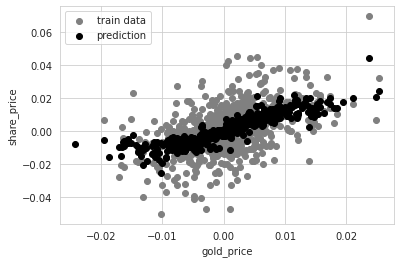

In [34]:
# We are going to have a look at how fitted data looks like:

plt_train_log=plt.scatter(x_train_log["gold_price"],y_train_log, color='grey')
plt_pred_log=plt.scatter(nmm15_log["gold_price"], regressor_log.predict(nmm15_log[["gold_price","GOLD","AU","KGC","NCM.AX"]]),  color='black')

plt.xlabel("gold_price")
plt.ylabel("share_price")
plt.legend((plt_train,plt_pred),("train data","prediction"))
plt.show()

Получившиеся модель выглядит действительно неплохою Помимо этого надо помнить, что в RandomForest есть еще много параметров для настройки, но ключевым из них является максимальная глубина, которая по дефолту неограничена. Дальше проверим, как эта модель предсказывает или тестирует данные.

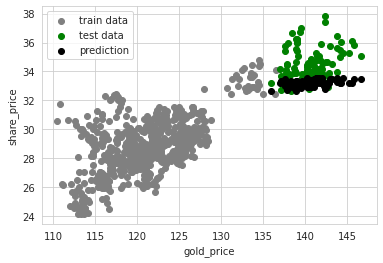

In [35]:
plt_train=plt.scatter(x_train["gold_price"],y_train,   color='grey')
plt_test=plt.scatter(x_test["gold_price"],y_test,   color='green')
plt_pred=plt.scatter(x_test["gold_price"], y_pred,  color='black')

plt.xlabel("gold_price")
plt.ylabel("share_price")
plt.legend((plt_train, plt_test,plt_pred),("train data", "test data","prediction"))
plt.show()

In [36]:
  # Узнать ошибки
  y_pred = clf.predict(x_test)
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
  print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 34.53631514792982
Mean Squared Error: 1193.9273933800678
Root Mean Squared Error: 34.553254454248844


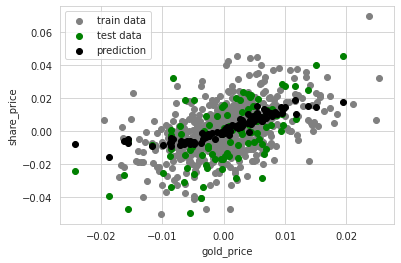

In [37]:
plt_train_log=plt.scatter(x_train_log["gold_price"],y_train_log,   color='grey')
plt_test_log=plt.scatter(x_test_log["gold_price"],y_test_log,   color='green')
plt_pred_log=plt.scatter(x_test_log["gold_price"], y_pred_log,  color='black')

plt.xlabel("gold_price")
plt.ylabel("share_price")
plt.legend((plt_train_log, plt_test_log,plt_pred_log),("train data", "test data","prediction"))
plt.show()

In [38]:
  # Узнать ошибки
  y_pred_log = clf.predict(x_test_log)
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_log, y_pred_log))  
  print('Mean Squared Error:', metrics.mean_squared_error(y_test_log, y_pred_log))  
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_log, y_pred_log)))

Mean Absolute Error: 0.012436596094071422
Mean Squared Error: 0.0002494355686193016
Root Mean Squared Error: 0.015793529327522128


Прогноз здесь выглядит немного хуже, чем при использование линейной регрессии. Но надо не забывать, что добавлены переменные, которые видимо не оказывают никакого влияния, а вносят только ошибку.

Feature ranking:
Feature gold_price (0.633889)
Feature GOLD (0.040664)
Feature AU (0.039888)
Feature KGC (0.037483)
Feature NCM.AX (0.248075)


Text(0, 0.5, 'Importance')

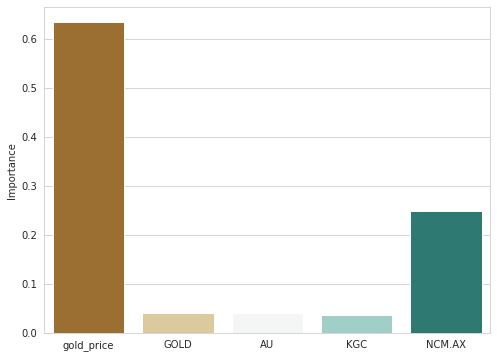

In [39]:
importances=regressor.feature_importances_

indices=list(x_train)
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("Feature %s (%f)" % (indices[f], importances[f]))

f, (ax1) = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
sns.barplot(indices, importances, palette="BrBG", ax=ax1)
ax1.set_ylabel("Importance")



По важности признаков сразу становиться ясным как сильное значение имеет цена золота.

Вкратце, надеюсь мне удалось вам раскрыть зачатки проекта по применению машинного обучения для исследования цены акций и надеюсь услышать от вас замечания.

In [40]:
df_plot = pd.DataFrame()
df_plot['Date'] = all_data_15[(all_data_15['name']=="NMM.SG") & (all_data_15['year']>2016 )]['Date'][-100:]
df_plot['pred'] = y_pred_list
df_plot['test'] =list(y_test['share_price'])
df_plot = df_plot.set_index('Date')

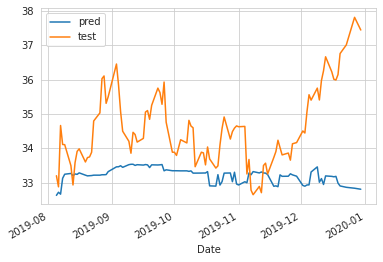

In [41]:
df_plot.plot()